## 优化问题


- 决策变量（decision variables）：待优化确定的参数
    - 对于神经网络，是 layer 的 parameters/weights；
    - 对于参数回归，是模型中待确定的参数；
    - pytorch 优化时，需要将所有的待优化确定的参数封装进 `optimizer` 中
    
    ```
    optimizer = torch.optim.Adam([x], lr=0.1)
    ```
- 目标函数（objective function）
    - 是关于决策变量的函数，w.r.t decision variables
    - 如任何一个需要最优化（最小/最大）的函数（Rosenbrock function）
        
        $$
        f(x)=\sum_{i=1}^{d-1}\left[100(x_{i+1}-x_i^2)^2+(x_i-1)^2\right]
        $$
        
    - 神经网络中的 loss function（to minimize）

- pytorch 的优化问题
    - 目标函数对决策变量（参数）可导；
    - 无约束；

## Rosenbrock function

In [11]:
import torch
from torch import nn
from torch.autograd import Variable

# 定义 Rosenbrock 函数
def rosenbrock(x):
    return sum(100.0 * (x[1:] - x[:-1] ** 2.0) ** 2.0 + (1 - x[:-1]) ** 2.0)

# 初始化参数向量，N = 10
# x = Variable(torch.randn(10), requires_grad=True)
x = nn.Parameter(torch.randn(5))

# 选择优化器
optimizer = torch.optim.Adam([x], lr=0.1)

# 优化循环
n_iter = 1000  # 迭代次数
for i in range(n_iter):
    optimizer.zero_grad()  # 清空梯度
    loss = rosenbrock(x)  # 计算损失
    loss.backward()  # 反向传播
    optimizer.step()  # 更新参数
    # 每1000次迭代打印一次损失值
    if i % 100 == 0:
        print(f"Iteration {i}: loss = {loss.item()}")
# 输出最终的参数值和损失值
x_final = x.detach().numpy()
final_loss = loss.item()
print(x_final)
print(final_loss)

Iteration 0: loss = 46.00251007080078
Iteration 100: loss = 0.3717646896839142
Iteration 200: loss = 0.04435967281460762
Iteration 300: loss = 0.0063514625653624535
Iteration 400: loss = 0.0009642678778618574
Iteration 500: loss = 0.00016229461471084505
Iteration 600: loss = 1.1787247785832733e-05
Iteration 700: loss = 0.0007104062242433429
Iteration 800: loss = 2.5467941213719314e-06
Iteration 900: loss = 0.003143133595585823
[0.99970233 0.9994302  0.9988302  0.9976877  0.9953527 ]
7.45456736694905e-06


## $a\cdot\exp(-k\cdot x) + b$：参数回归

In [31]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from torch import nn
from torch.functional import F
from copy import copy
import seaborn as sns
from tqdm.notebook import tqdm
sns.set_style("whitegrid")

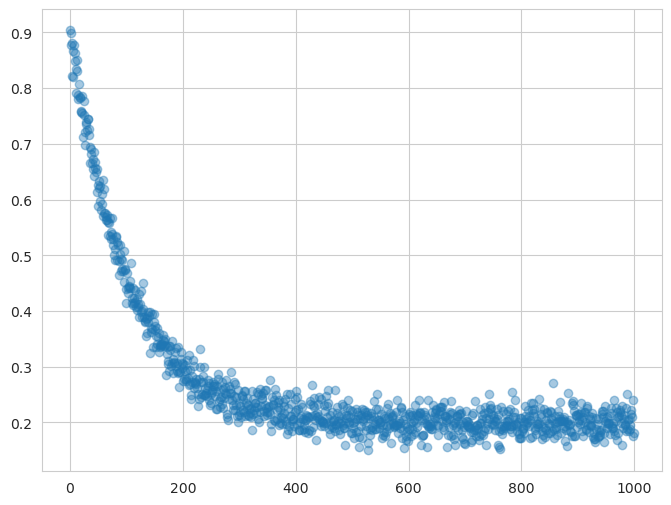

In [15]:
N = 1000
noise = torch.Tensor(np.random.normal(0, 0.02, size=N))
x = torch.arange(N)
a, k, b = 0.7, .01, 0.2
y = a * np.exp(-k * x) + b + noise
plt.figure(figsize=(8, 6))
plt.scatter(x, y, alpha=0.4)

In [16]:
class RegModel(nn.Module):
    """Custom Pytorch model for gradient optimization.
    """
    def __init__(self):
        
        super().__init__()
        # initialize weights with random numbers
        weights = torch.distributions.Uniform(0, 0.1).sample((3,))
        # make weights torch parameters
        self.weights = nn.Parameter(weights)        
        
    def forward(self, X):
        """Implement function to be optimised. In this case, an exponential decay
        function (a + exp(-k * X) + b),
        """
        a, k, b = self.weights
        return a * torch.exp(-k * X) + b

In [32]:
model = RegModel()

In [33]:
list(model.named_parameters())

[('weights',
  Parameter containing:
  tensor([0.0454, 0.0659, 0.0034], requires_grad=True))]

In [34]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [35]:
losses = []
for i in tqdm(range(1000)):
    optimizer.zero_grad()
    preds = model(x)
    loss = F.mse_loss(preds, y).sqrt()
    loss.backward()
    optimizer.step()
    losses.append(loss.detach().numpy())  

  0%|          | 0/1000 [00:00<?, ?it/s]

In [36]:
model.weights

Parameter containing:
tensor([0.6870, 0.0097, 0.1997], requires_grad=True)

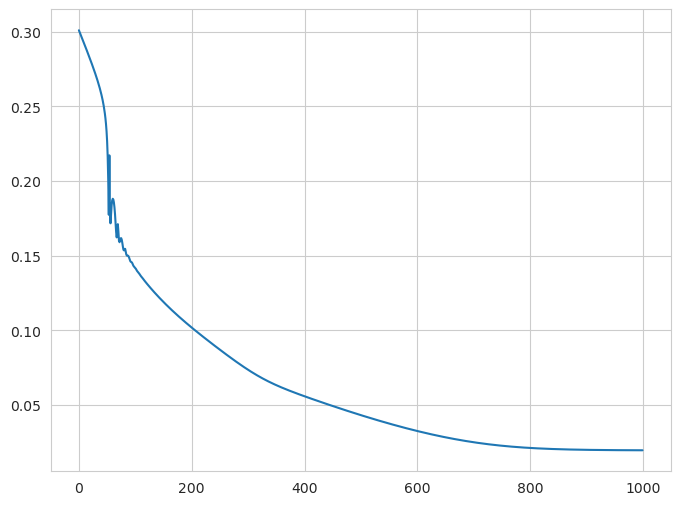

In [37]:
plt.figure(figsize=(8, 6))
plt.plot(losses)

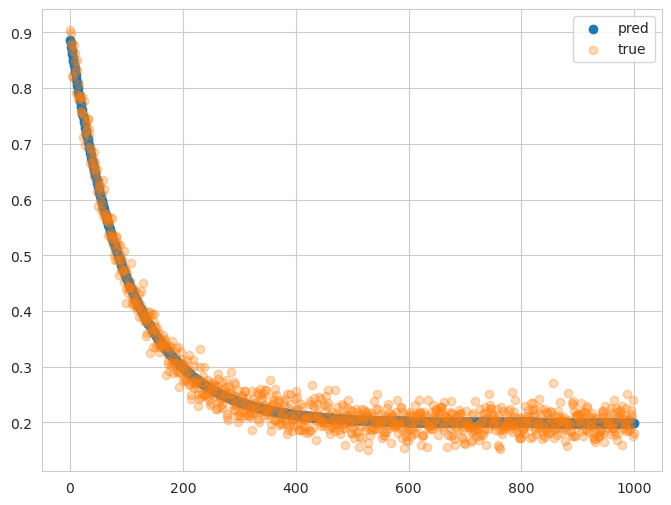

In [42]:
preds = model(x)
plt.figure(figsize=(8, 6))
plt.scatter(x, preds.detach().numpy(), label='pred')
plt.scatter(x, y, alpha=.3, label='true')
plt.legend()